In [ ]:
## This code is used to build a classifier using dataset 
## from Yahoo Finance. Training on historical OHLC (open, 
## high, low close) data of the nine ETFs "XLE", "XLU", 
## "XLK", "XLB", "XLP", "XLY", "XLI", "XLV", "SPY And by 
## this predictive model, to develop the Buy/Sell strategy 
## to apply on 2016’s market. 

##-- Dataset downloading
import pandas as pd
import pandas.io.data as web
import datetime

#--Specify start and end time; specify required symbols
#--Request data from earlist date to end of 2016. 
#--Data till end of 2015 will be in-sample training/testing set. 
#--Data of 2016 will be evaluating set.
start = datetime.datetime(1998, 12, 22)
end = datetime.datetime(2016, 12, 31)
etfnames = ["XLE", "XLU", "XLK", "XLB", "XLP", "XLY", 
          "XLI", "XLV", "SPY"]


#--Download dataframe one-by-one then combine as a whole dataframe
buff = []
for i in range(9):
    rawdf = web.DataReader(etfnames[i], 'yahoo', start, end)
    rawdf['symbol'] = etfnames[i]  
    #add etfnames and etfcode to dataframe
    rawdf['symbolcode'] = i;
    buff.append(rawdf)
rawdf = pd.concat(buff)
rawdf['trend'] = ((rawdf['Close'] - rawdf['Open']) > 0).astype(int)
rawdf['ratings']= ((rawdf['Close'] - rawdf['Open']) / rawdf['Close'])

## Rate the historical stock price trend, 
## for daily 0.5% as an increment. Up to +/- 1.5%
for i in range(len(rawdf)):
    if rawdf['ratings'].iat[i] > 0.005 * 2:
        rawdf.set_value(i, 9, 3, takeable = True)
    elif rawdf['ratings'].iat[i] > 0.005 * 1:
        rawdf.set_value(i, 9, 2, takeable = True)
    elif rawdf['ratings'].iat[i] > 0.005 * 0:
        rawdf.set_value(i, 9, 1, takeable = True)
    elif rawdf['ratings'].iat[i] > 0.005 * -1:
        rawdf.set_value(i, 9, -1, takeable = True)
    elif rawdf['ratings'].iat[i] > 0.005 * -2:
        rawdf.set_value(i, 9, -2, takeable = True)
    else :
        rawdf.set_value(i, 9, -3, takeable = True)
print('Finishing Raw data of trials')
print(len(rawdf))


#--Split data to in-sample and out-sample
#--Data till end of 2015 will be in-sample training/testing set. 
#--Data of 2016 will be evaluating set.
buff = []
for i in range(9):
    df_in = rawdf[rawdf['symbolcode'] == i][:-252]
    buff.append(df_in)
df_in=pd.concat(buff)
print('In-sample training/testing set, data size:')
print(len(df_in))
buff = []
for i in range(9):
    df_out = rawdf[rawdf['symbolcode']==i][-252-252-10:]
    buff.append(df_out)
df_out=pd.concat(buff)
print('Out-sample evaluating set set, data size:')
print(len(df_out))

In [ ]:
##--Build the sklearn transformer. 
##--To tramsform the raw dataset into machine recognizable vectors. 

from sklearn import base #Use sklearn base template
import numpy as np


class FeatureSelectTransform(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, model_flag, etfcode):
        self.model_flag = model_flag        
        # Specify a model flag and respective ETF name
        self.etfcode = etfcode
    
    def fit(self, rawdf, y=None):
        return self
    
    def transform(self, rawdf):
        outx=[]
        outy=[]
        outweight=[]
        output=[]                            
        # The trasformed matrix will be [Features, Outputs, Weights]
        if self.model_flag == 'self':
            subdf=rawdf[rawdf['symbolcode'] == self.etfcode]  
            # specify a subdf to model particular ETF
            for j in range(252+10,len(subdf)):
                buff=[999]*11    ##initialize features,100
                buff[0:2]=(subdf['Open'][j-2:j].values.tolist()
                           /df_out['Open'][j-50:j].values.mean())
                buff[4:4]=(subdf['High'][j-2:j].values.tolist()
                           /df_out['High'][j-50:j].values.mean())
                buff[4:6]=(subdf['Low'][j-2:j].values.tolist()
                           /df_out['Low'][j-50:j].values.mean())
                buff[6:8]=(subdf['Close'][j-2:j].values.tolist()
                           /df_out['Close'][j-50:j].values.mean())
                buff[8:10]=(subdf['Volume'][j-2:j].values.tolist()
                            /df_out['Volume'][j-50:j].values.mean())
                buff[11]=int(np.asarray(
                        subdf['trend'][j-5:j].values.tolist()),2)
                outx.append(buff)
            for j in range(252+10,len(subdf)):
                outy.append(subdf['trend'].iat[j])
                outweight.append(subdf['ratings'].iat[j]) 
                ##using rating as its trend
            output.append(outx)
            output.append(outy)
            output.append(outweight)
            return output
        elif self.model_flag == 'period':
            subdf=rawdf[rawdf['symbolcode'] == self.etfcode]
            for j in range(252+10,len(subdf)):
                buff=[999]*(3)    ##initialize features,100
                buff[0]=subdf['trend'][j-252-10:j-252+10].values.sum()/20
                buff[1]=subdf['trend'][j-63-10:j-63+10].values.sum()/20
                buff[2]=subdf['trend'][j-5:j-4].values.sum()
                outx.append(buff)
            for j in range(252+10,len(subdf)):
                outy.append(subdf['trend'].iat[j])
                outweight.append(subdf['ratings'].iat[j])
            output.append(outx)
            output.append(outy)
            output.append(outweight)
            return output
        elif self.model_flag == 'cross':   
            ####model1 is full model both cross data and self data
            subdf=rawdf[rawdf['symbolcode'] == self.etfcode]
            for j in range(252+10,len(subdf)):
                buff=[999]*(20+10+20*5+20*8)    
                ##initialize features; seasonal 30,self 20*5, xcorr20*8
                buff[0:20]=subdf['trend'][j-252-10:j-252+10
                            ].values.tolist()
                buff[20:20+10]=subdf['trend'][j-60-5:j-60+5
                            ].values.tolist()
                buff[30:30+20]=subdf['Open'][j-20:j
                            ].values.tolist()
                buff[50:50+20]=subdf['High'][j-20:j
                            ].values.tolist()    
                buff[70:70+20]=subdf['Low'][j-20:j
                            ].values.tolist()
                buff[90:90+20]=subdf['Close'][j-20:j
                             ].values.tolist()
                buff[110:110+20]=subdf['Volume'][j-20:j
                             ].values.tolist()
                buff[130:130+160]=rawdf[rawdf['symbolcode']!=i
                             ].ix[subdf.iloc[j-20:j].index
                             ]['trend'].values.tolist()
                outx.append(buff)
            for j in range(252+10,len(subdf)):
                outy.append(subdf['ratings'].iat[j])
            output.append(outx)
            output.append(outy)
            return output
        # Return an array with the same number of rows as X and one
        # column for each in self.col_names

In [ ]:
## build pipeline for machine learning using 
## Neural network and SVM

from sklearn.neural_network import MLPClassifier
from sklearn.svm import NuSVC
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline


strategy=[] # for the output strategy of 9 etfs

for etf in range(9):    
    #firstly model the historical self model
    fst1=FeatureSelectTransform('self',etf);  
    training1=fst.fit_transform(df_in)
    xarray1 = np.asarray(training[0])
    yarray1 = np.asarray(training[1]).astype(int)
    weightarray= np.asarray(training[2]).astype(int)
    clf1=NuSVC(u=0.7, gamma=1)
    clf1.fit(xarray1,yarry1)
    
    #then model the periodic market turbulence
    fst2=FeatureSelectTransform('period',etf);  
    training2=fst.fit_transform(df_in)
    xarray2 = np.asarray(training[0])
    yarray2 = np.asarray(training[1]).astype(int)
    weightarray= np.asarray(training[2]).astype(int)
    clf2=NuSVC(u=0.9, gamma=1/3)
    clf2.fit(xarray2,yarry2)
    
    ##then model the cross correlation of other stocks
    fst3=FeatureSelectTransform('cross',etf);  
    training2=fst3.fit_transform(df_in)
    xarray2 = np.asarray(training[0])
    yarray3 = np.asarray(training[1]).astype(int)
    weightarray= np.asarray(training[2]).astype(int)
    clf3=MLPClassifier(solver='lbfgs', 
                       alpha=0,hidden_layer_sizes=(200,50), 
                       random_state=2,early_stopping=True)
    clf3.fit(xarray3,yarry3)
    
    ##build the feature union to combine these models
    union = FeatureUnion([('self',clf1(rawdf)),
                      ('period',clf1(rawdf)),
                      ('cross',clf1(rawdf))
    ])
    union.fit(xarray3, yarray3)
    full = Pipeline([('features', union),
                 ('regressor', Ridge(alpha=50))
    ])
    full.fit(xarray3,xarray3)
    evaluating=fst3(out_df)
    actions=full.predict(evaluating[0])
    strategy.append(actions)
    
    print("finished modeling ETF"+etfnames[etf])

In [49]:
## Check on the builed strategy, output to sumarized P&L for every ETFs
## Follow the actions 1 for buy and 0 for sell

sumr=0

for etf in range(0,9):
    actions=strategy[etf]
    revenue=[];
    for i in range(252):
        if actions[i]>0:
            revenue.append((
              df_out[df_out['symbolcode']==etf]['Close'].iat[252+10+i]
              -df_out[df_out['symbolcode']==etf]['Open'].iat[252+10+i])
              /df_out[df_out['symbolcode']==etf]['Open'].iat[252+10+i])
        else:
            revenue.append((
              df_out[df_out['symbolcode']==etf]['Open'].iat[252+10+i]
              -df_out[df_out['symbolcode']==etf]['Close'].iat[252+10+i])
              /df_out[df_out['symbolcode']==etf]['Open'].iat[252+10+i])
    print(sum(revenue))
    sumr=sumr+sum(revenue)
print('___________')
print(sumr)

0.530885929473
0.32427165083
0.193523324012
0.363345045368
0.121520401275
0.130902177711
0.270714696153
0.203680751905
0.163434589315
___________
2.30227856604


In [51]:
## Compare Revenue with SPY-Long-Only and All-Long-Olny strategy
## Calculate the cumulative daily portfolio P&L

benchmark_spy=[];
benchmark_all=[];
revenue=[];

for day in range(252):
    benchmark_spy_day=0
    benchmark_all_day=0
    revenue_day=0
    for etf in range(9):
        # follow two benchmark strategy
        benchmark_spy_day=(benchmark_spy_day
            +((df_out[df_out['symbolcode']==8]['Close'].iat[252+10+day]
            -df_out[df_out['symbolcode']==8]['Open'].iat[252+10+day])
            /df_out[df_out['symbolcode']==8]['Open'].iat[252+10+day]))
        benchmark_all_day=(benchmark_all_day
             +((df_out[df_out['symbolcode']==etf]['Close'].iat[252+10+day]
            -df_out[df_out['symbolcode']==etf]['Open'].iat[252+10+day])
            /df_out[df_out['symbolcode']==etf]['Open'].iat[252+10+day]))
        # Follow the model strategy
        if strategy[etf][day]>0:
            revenue_day=(revenue_day
            +((df_out[df_out['symbolcode']==etf]['Close'].iat[252+10+day]
            -df_out[df_out['symbolcode']==etf]['Open'].iat[252+10+day])
            /df_out[df_out['symbolcode']==etf]['Open'].iat[252+10+day]))
        else:
            revenue_day=(revenue_day
            +((df_out[df_out['symbolcode']==etf]['Open'].iat[252+10+day]
            -df_out[df_out['symbolcode']==etf]['Close'].iat[252+10+day])
            /df_out[df_out['symbolcode']==etf]['Open'].iat[252+10+day]))
    benchmark_spy.append(benchmark_spy_day)
    benchmark_all.append(benchmark_all_day)
    revenue.append(revenue_day)

## print out cumulative daily portfolio P&L at end of year 2016

print(sum(benchmark_spy))
print(sum(benchmark_all))
print(sum(revenue))

1.35873942924
1.65013055977
2.30227856604


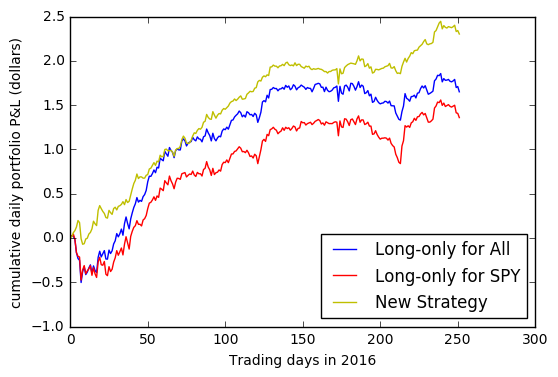

In [52]:
## Plot for the cumulative daily portfolio P&L

import matplotlib.pyplot as plt
import matplotlib
sum_revenue=[]
sum_benchmark_spy=[]
sum_benchmark_all=[]
for i in range(len(benchmark_spy)):
#    sum_revenue.append(sum(revenue[0:i+1]))
    sum_benchmark_spy.append(sum(benchmark_spy[0:i+1]))
    sum_benchmark_all.append(sum(benchmark_all[0:i+1]))
    sum_revenue.append(sum(revenue[0:i+1]))

plt.plot(sum_benchmark_all, 'b-', label='Long-only for All')
plt.plot(sum_benchmark_spy, 'r-', label='Long-only for SPY')
plt.plot(sum_revenue,'y-', label= 'New Strategy')
plt.legend(loc='lower right', frameon=True)
plt.ylabel('cumulative daily portfolio P&L (dollars)')
plt.xlabel('Trading days in 2016')
plt.show()




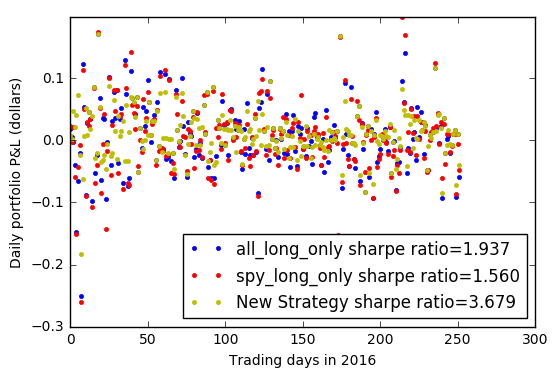

In [53]:
## Plot data performance and calculate annualized Sharpe ratio

import numpy as np

plt.plot(benchmark_all, 'b.', label=
         'all_long_only sharpe ratio='
         +str(np.mean(benchmark_all)
              /np.std(benchmark_all)
              *np.sqrt(252))[0:5])
plt.plot(benchmark_spy, 'r.', label=
        'spy_long_only sharpe ratio='
         +str(np.mean(benchmark_spy)
        /np.std(benchmark_spy)*np.sqrt(252))[0:5])
plt.plot(revenue,'y.', label= 
        'New Strategy sharpe ratio='
         +str(np.mean(revenue)
        /np.std(revenue)*np.sqrt(252))[0:5])

plt.legend(loc='lower right', frameon=True)
plt.ylabel('Daily portfolio P&L (dollars)')
plt.xlabel('Trading days in 2016')
plt.show()

